In [38]:
import numpy as np 
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from aare import ClusterFinder, calculate_eta2, Interpolator
import boost_histogram as bh
from aare._aare import Cluster2x2d, ClusterVector_Cluster2x2d

In [ ]:
### create frame of one photon hit using gaussian distribution 
def create_photon_hit_with_gaussian_distribution(mean, covariance_matrix, data_points):
    gaussian = multivariate_normal(mean=mean, cov=covariance_matrix)
    probability_values = gaussian.pdf(data_points)
    return (probability_values.reshape(X.shape)).round() #python bindings only support frame types of uint16_t


def calculate_scaled_photon_hit(cluster_center_in_subpixels, pixels_per_superpixel, photon_hit): 
    scaled_photon_hit_x = cluster_center_in_subpixels - (1 - photon_hit[0][0])*0.5*pixels_per_superpixel 
    scaled_photon_hit_y = cluster_center_in_subpixels - (1 - photon_hit[0][1])*0.5*pixels_per_superpixel
    return [scaled_photon_hit_x, scaled_photon_hit_y]


In [ ]:
### plotting functions

def plot_eta_distribution(hist):
    plt.imshow(
    hist[:, :, 0].to_numpy(view=True).transpose(),   
    origin='lower',                  
    extent=[hist.axes[0].edges[0], hist.axes[0].edges[-1], hist.axes[1].edges[0], hist.axes[1].edges[-1]],
    aspect='auto')
    plt.colorbar()
    plt.xlabel('eta_x')
    plt.ylabel('eta_y')

def plot_uniform_eta_distribution(uniform_etax, uniform_etay, eta_extent): 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # (rows, cols)

    im1 = axes[0].imshow(
    uniform_etax[:, :, 0].to_numpy(view=True).transpose(),   
    origin='lower',                  
    extent=[eta_extent[0], eta_extent[1], eta_extent[0], eta_extent[1]],
    aspect='auto'
    )
    axes[0].set_title("uniform distribution of etax")
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    axes[0].set_xlabel("eta_x")
    axes[0].set_ylabel("eta_y")

    im2 = axes[1].imshow(
    uniform_etay[:, :, 0].to_numpy(view=True).transpose(),   
    origin='lower',                  
    extent=[eta_extent[0], eta_extent[1], eta_extent[0], eta_extent[1]],
    aspect='auto'
    )
    axes[1].set_title("uniform distribution of etay")
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    axes[1].set_xlabel("eta_x")
    axes[1].set_ylabel("eta_y")

    plt.tight_layout()
    plt.show()

In [146]:
pixel_width = 1e-4

values = np.arange(0.5*pixel_width, 0.1, pixel_width)

num_pixels = values.size

print(f"num pixels: ({values.size} x {values.size})")

X, Y = np.meshgrid(values, values)

data_points = np.stack([X.ravel(), Y.ravel()], axis=1)

num pixels: (1000 x 1000)


Text(0, 0.5, 'y_0')

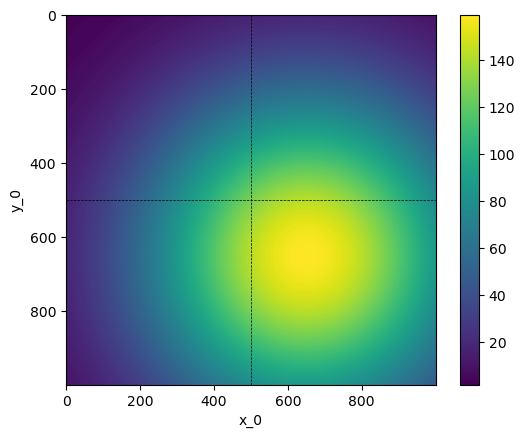

In [158]:
# mean is in bottom right quadrant 
variance = 10*pixel_width

covariance_matrix = np.array([[variance, 0], [0, variance]])

mean = 650*pixel_width

mean = np.array([mean, mean])

base_frame = create_photon_hit_with_gaussian_distribution(mean, variance, data_points)

pixels_per_superpixel = int(num_pixels*0.5)

plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('x_0')
plt.ylabel('y_0')

In [176]:
### create eta distribution
num_frames = 1000

hist = bh.Histogram(
    bh.axis.Regular(100, -0.2, 1.2), 
    bh.axis.Regular(100, -0.2, 1.2), bh.axis.Regular(1, 0, num_pixels*num_pixels*1/(variance*2*np.pi))) 

print("max energy: ", 4*num_pixels*num_pixels*1/(variance*2*np.pi))

for frame_index in range(0, num_frames):
    mean_x = np.random.uniform(num_pixels*0.5*pixel_width, num_pixels*pixel_width)
    mean_y = np.random.uniform(num_pixels*0.5*pixel_width, num_pixels*pixel_width)
    frame = create_photon_hit_with_gaussian_distribution(np.array([mean_x, mean_y]), variance, data_points)

    cluster = Cluster2x2d(1, 1, np.array([frame[0:pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                          frame[0:pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                          frame[pixels_per_superpixel:2*pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                          frame[pixels_per_superpixel:2*pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum()], dtype=np.float64))
    
    eta2 = calculate_eta2(cluster)
    hist.fill(eta2[0], eta2[1], eta2[2])

plot_eta_distribution(hist)

max energy:  636619772.3675814


AttributeError: 'Histogram' object has no attribute 'transpose'

In [132]:
interpolator = Interpolator(hist, hist.axes[0].edges[:-1], hist.axes[1].edges[:-1], hist.axes[2].edges[:-1])

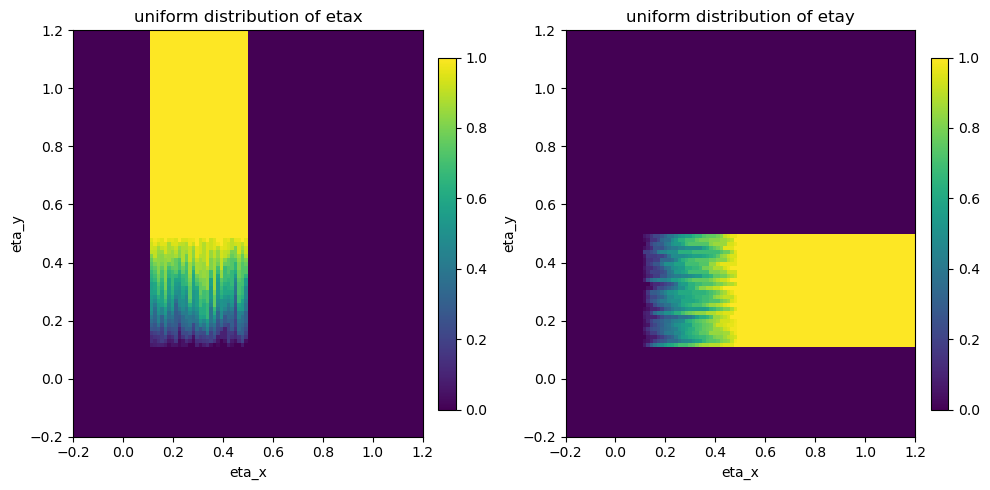

In [ ]:
uniform_etax = interpolator.get_ietax()
uniform_etay = interpolator.get_ietay()

plot_uniform_eta_distribution(uniform_etax, uniform_etay, [hist.axes[0].edges[0], hist.axes[0].edges[-1]])

In [163]:

cluster = Cluster2x2d(1, 1, np.array([base_frame[0:pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                      base_frame[0:pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                      base_frame[pixels_per_superpixel:2*pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                      base_frame[pixels_per_superpixel:2*pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum()], dtype=np.float64))

clustervec = ClusterVector_Cluster2x2d()
clustervec.push_back(cluster)

eta = calculate_eta2(cluster)
print("eta: ", eta)
bin_size = (hist.axes[0].edges[-1] - hist.axes[0].edges[0])/hist.axes[0].edges.shape[0]

bin_index_x = int((eta[0] - hist.axes[0].edges[0])/bin_size)
bin_index_y = int((eta[1] - hist.axes[1].edges[0])/bin_size)

print("distance x:", uniform_etax[bin_index_x, bin_index_y, 0])
print("distance y:", uniform_etay[bin_index_x, bin_index_y, 0])

photon_hit = interpolator.interpolate(clustervec)

print(photon_hit)



eta:  (0.3519491547025806, 0.3519491547025806, 71553511.0)
distance x: 0.6923076923076923
distance y: 0.6363636363636364
[(-0.38461538, -0.27272727, 71553511.)]


In [165]:
# scale to cluster pixel width 
cluster_center_in_subpixels = num_pixels*0.75
scaled_photon_hit = calculate_scaled_photon_hit(cluster_center_in_subpixels, pixels_per_superpixel, photon_hit)

print(f"previous center: ({cluster_center_in_subpixels}, {cluster_center_in_subpixels})")
print(f"interpolated center: ({photon_hit[0][0]},{photon_hit[0][1]})")
print(f"scaled interpolated center: ({scaled_photon_hit[0]},{scaled_photon_hit[1]})")
print(f"actual center: ({mean/pixel_width},{mean/pixel_width})")

previous center: (750.0, 750.0)
interpolated center: (-0.3846153846153846,-0.2727272727272727)
scaled interpolated center: (403.84615384615387,431.8181818181818)
actual center: ([650. 650.],[650. 650.])


Text(0, 0.5, 'y_0')

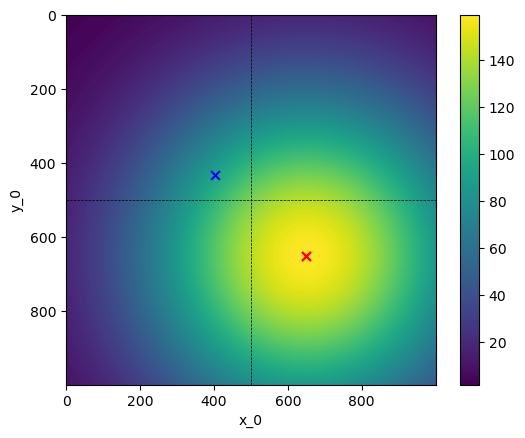

In [166]:
plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.scatter(mean/pixel_width, mean/pixel_width, color='red', s=40, marker='x', label='Actual photon hit')
plt.scatter(scaled_photon_hit[0], scaled_photon_hit[1], color = 'blue', s=40, marker='x', label='interpolated photon hit')

plt.xlabel('x_0')
plt.ylabel('y_0')

## 3x3 Cluster

In [75]:
from aare._aare import Cluster3x3d, ClusterVector_Cluster3x3d

Text(0, 0.5, 'y_0')

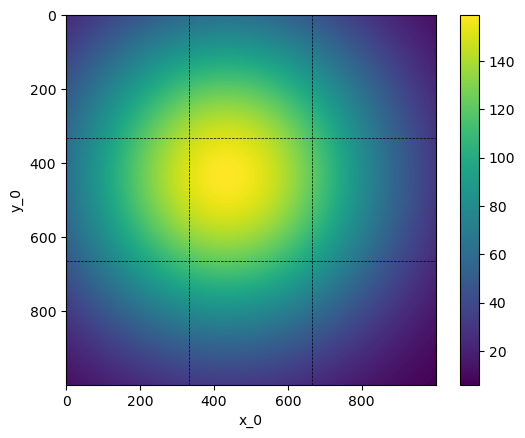

In [167]:
# mean is in center quadrant 
variance = 10*pixel_width

covariance_matrix = np.array([[variance, 0], [0, variance]])

mean = (1 + 0.3)*(num_pixels/3)*pixel_width

mean = np.array([mean, mean])

base_frame = create_photon_hit_with_gaussian_distribution(mean, variance, data_points)

pixels_per_superpixel = int(num_pixels/3)

plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.xlabel('x_0')
plt.ylabel('y_0')

In [168]:
### calculate eta distribution

num_frames = 1000

hist = bh.Histogram(
    bh.axis.Regular(100, -0.2, 1.2), 
    bh.axis.Regular(100, -0.2, 1.2), bh.axis.Regular(1, 0, num_pixels*num_pixels*1/(variance*2*np.pi))) 

print("max energy: ", 4*num_pixels*num_pixels*1/(variance*2*np.pi))

for frame_index in range(0, num_frames):
    mean_x = np.random.uniform(pixels_per_superpixel*pixel_width, 2*pixels_per_superpixel*pixel_width)
    mean_y = np.random.uniform(pixels_per_superpixel*pixel_width, 2*pixels_per_superpixel*pixel_width) 
    frame = create_photon_hit_with_gaussian_distribution(np.array([mean_x, mean_y]), variance, data_points)

    cluster = Cluster3x3d(1, 1, np.array([frame[0:pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                    frame[0:pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                    frame[0:pixels_per_superpixel, 2*pixels_per_superpixel:3*pixels_per_superpixel].sum(), 
                                    frame[pixels_per_superpixel:2*pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                    frame[pixels_per_superpixel:2*pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                    frame[pixels_per_superpixel:2*pixels_per_superpixel, 2*pixels_per_superpixel:3*pixels_per_superpixel].sum(), 
                                    frame[2*pixels_per_superpixel:3*pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                    frame[2*pixels_per_superpixel:3*pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                    frame[2*pixels_per_superpixel:3*pixels_per_superpixel, 2*pixels_per_superpixel:3*pixels_per_superpixel].sum()], dtype=np.float64))
    
    eta2 = calculate_eta2(cluster)
    #print(eta2)
    hist.fill(eta2[0], eta2[1], eta2[2])

max energy:  636619772.3675814


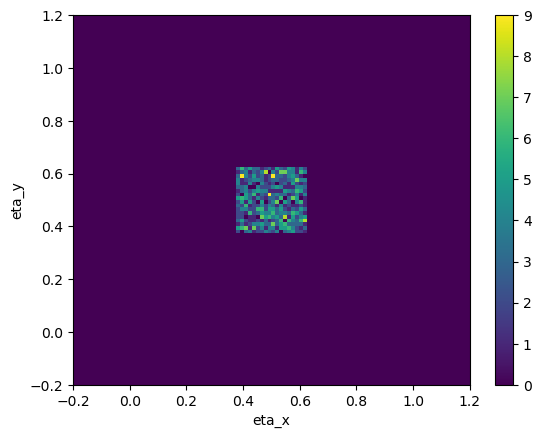

In [169]:
plot_eta_distribution(hist)

In [170]:
interpolator = Interpolator(hist, hist.axes[0].edges[:-1], hist.axes[1].edges[:-1], hist.axes[2].edges[:-1])

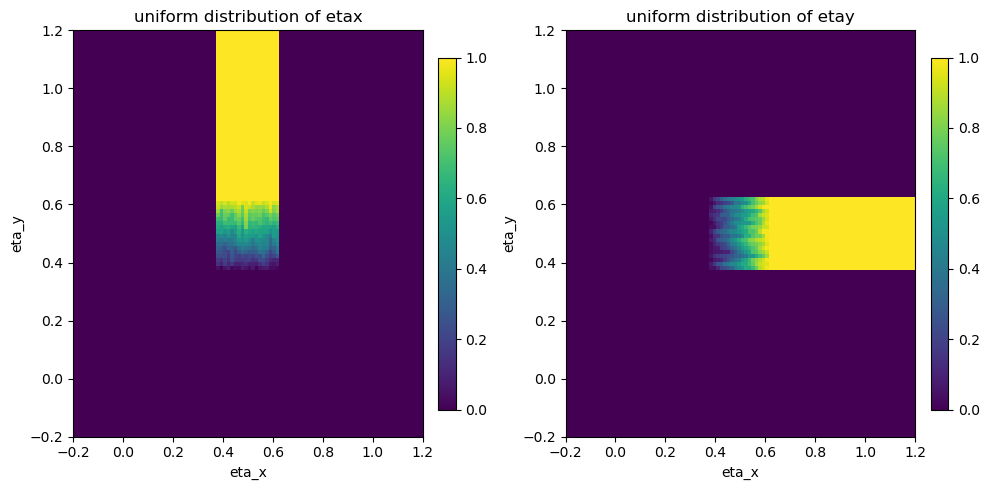

In [171]:
uniform_etax = interpolator.get_ietax()
uniform_etay = interpolator.get_ietay()

plot_uniform_eta_distribution(uniform_etax, uniform_etay, [hist.axes[0].edges[0], hist.axes[0].edges[-1]])

In [172]:

cluster = Cluster3x3d(1, 1, np.array([base_frame[0:pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                    base_frame[0:pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                    base_frame[0:pixels_per_superpixel, 2*pixels_per_superpixel:3*pixels_per_superpixel].sum(), 
                                    base_frame[pixels_per_superpixel:2*pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                    base_frame[pixels_per_superpixel:2*pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                    base_frame[pixels_per_superpixel:2*pixels_per_superpixel, 2*pixels_per_superpixel:3*pixels_per_superpixel].sum(), 
                                    base_frame[2*pixels_per_superpixel:3*pixels_per_superpixel, 0:pixels_per_superpixel].sum(), 
                                    base_frame[2*pixels_per_superpixel:3*pixels_per_superpixel, pixels_per_superpixel:2*pixels_per_superpixel].sum(), 
                                    base_frame[2*pixels_per_superpixel:3*pixels_per_superpixel, 2*pixels_per_superpixel:3*pixels_per_superpixel].sum()], dtype=np.float64))
clustervec = ClusterVector_Cluster3x3d()
clustervec.push_back(cluster)

photon_hit = interpolator.interpolate(clustervec)

In [173]:
## scale to cluster pixel width 
cluster_center_in_subpixels = (1+0.5)*pixels_per_superpixel

scaled_photon_hit = calculate_scaled_photon_hit(cluster_center_in_subpixels, pixels_per_superpixel, photon_hit)

print(f"previous center: ({cluster_center_in_subpixels}, {cluster_center_in_subpixels})")
print(f"interpolated center: ({photon_hit[0][0]},{photon_hit[0][1]})")
print(f"scaled interpolated center: ({scaled_photon_hit[0]},{scaled_photon_hit[1]})")
print(f"actual center: ({mean/pixel_width},{mean/pixel_width})")

previous center: (499.5, 499.5)
interpolated center: (0.6521739130434783,0.6140350877192983)
scaled interpolated center: (441.5869565217391,435.2368421052632)
actual center: ([433.33333333 433.33333333],[433.33333333 433.33333333])


Text(0, 0.5, 'y_0')

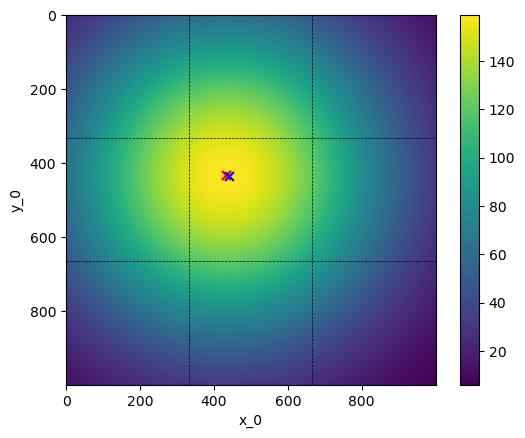

In [174]:
plt.imshow(base_frame) 

plt.colorbar()

plt.axvline(x=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=2*pixels_per_superpixel, color='black', linestyle='--', linewidth=0.5)

plt.scatter(mean/pixel_width, mean/pixel_width, color='red', s=40, marker='x', label='Actual photon hit')
plt.scatter(scaled_photon_hit[0], scaled_photon_hit[1], color = 'blue', s=40, marker='x', label='interpolated photon hit')

plt.xlabel('x_0')
plt.ylabel('y_0')